In [1]:
from transformers import AutoTokenizer
import pandas as pd
import torch
from tqdm import tqdm
from transformers import BertModel
import torch
import matplotlib.pyplot as plt

In [13]:
class Data(torch.utils.data.Dataset):
    def __init__(self, path):
        df = pd.read_csv(path, sep="\t")
        df = df.dropna()
        tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        df['training'] = df.apply(lambda x: str(x['sentence1']) + str(' [SEP] ') + str(x['sentence2']), axis=1)
        df['tokenized'] = df['training'].apply(lambda x: tokenizer.encode_plus(x, return_tensors='pt', padding=True, truncation=True,add_special_tokens=True))
        df['input_ids'] = df['tokenized'].apply(lambda x: x['input_ids'][0])
        df['attention_mask'] = df['tokenized'].apply(lambda x: x['attention_mask'][0])
        df['label'] = df['score'].apply(lambda x: torch.tensor(x/5.0))
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df['input_ids'][idx], self.df['attention_mask'][idx], self.df['label'][idx]


def collate_fn(batch):
    input_ids = torch.nn.utils.rnn.pad_sequence([x[0] for x in batch],batch_first=True)
    attention_mask = torch.nn.utils.rnn.pad_sequence([x[1] for x in batch],batch_first=True)
    label = torch.stack([x[2] for x in batch]).unsqueeze(1)
    return input_ids, attention_mask, label


def train(
        model=None, train_dataloader=None, validation_dataloader=None, epochs=6,
        loss_fn=torch.nn.functional.mse_loss, lr=1e-3, batch_size=16
    ):
    if train_dataloader is None:
        train_dataset = Data('Data/train.csv')
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    if validation_dataloader is None:
        validation_dataset = Data('Data/dev.csv')
        validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = 1e9

    TRAIN_LOSSES = []
    VAL_LOSSES = []

    for i in range(epochs):
        print('Training for epoch',i+1)
        total_loss = 0
        for input_ids, attention_mask, label in tqdm(train_dataloader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(input_ids, attention_mask)
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                total_loss += loss.item()
        print('Training loss',total_loss/len(train_dataloader))
        TRAIN_LOSSES.append(total_loss/len(train_dataloader))

        total_loss = 0
        print('Validation for epoch',i+1)
        with torch.no_grad():
            total_loss = 0
            for input_ids, attention_mask, label in tqdm(validation_dataloader):
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                label = label.to(device)
                output = model(input_ids, attention_mask)
                loss = loss_fn(output, label)
                total_loss += loss.item()
            print('Validation loss',total_loss/len(validation_dataloader))
            VAL_LOSSES.append(total_loss/len(validation_dataloader))

            if total_loss < best_val_loss:
                best_val_loss = total_loss
                torch.save(model.state_dict(), 'model.pth')
                print('Model saved')

    return model, TRAIN_LOSSES, VAL_LOSSES


class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc1 = torch.nn.Linear(768, 40)
        self.fc2 = torch.nn.Linear(40, 1)

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask)
        x = x['last_hidden_state'][:,0,:] #CLS token
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.nn.functional.sigmoid(x)
        return x

In [14]:
model, TRAIN_LOSSES, VAL_LOSSES = train(model=Model(), loss_fn=torch.nn.BCELoss())

Training for epoch 1


100%|██████████| 357/357 [01:07<00:00,  5.26it/s]


Training loss 0.694201863780409
Validation for epoch 1


100%|██████████| 92/92 [00:04<00:00, 19.21it/s]


Validation loss 0.6955388739057209
Model saved
Training for epoch 2


100%|██████████| 357/357 [01:08<00:00,  5.23it/s]


Training loss 0.6907363061477491
Validation for epoch 2


100%|██████████| 92/92 [00:04<00:00, 19.28it/s]


Validation loss 0.6969964504241943
Training for epoch 3


100%|██████████| 357/357 [01:07<00:00,  5.27it/s]


Training loss 0.6901309984404834
Validation for epoch 3


100%|██████████| 92/92 [00:04<00:00, 19.07it/s]


Validation loss 0.7015329340229863
Training for epoch 4


100%|██████████| 357/357 [01:06<00:00,  5.36it/s]


Training loss 0.690444099635971
Validation for epoch 4


100%|██████████| 92/92 [00:04<00:00, 19.00it/s]


Validation loss 0.7001116185084634
Training for epoch 5


100%|██████████| 357/357 [01:07<00:00,  5.28it/s]


Training loss 0.6910133012870446
Validation for epoch 5


100%|██████████| 92/92 [00:04<00:00, 19.07it/s]


Validation loss 0.7014573857836102
Training for epoch 6


100%|██████████| 357/357 [01:06<00:00,  5.35it/s]


Training loss 0.6905805141318078
Validation for epoch 6


100%|██████████| 92/92 [00:04<00:00, 19.09it/s]

Validation loss 0.7039760020763978


In [16]:
torch.save(model.state_dict(), f"MODEL_1A.pth")

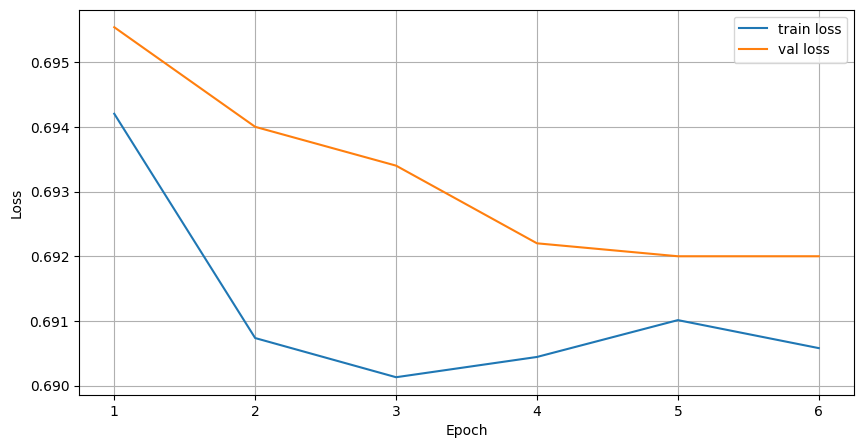

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 7), TRAIN_LOSSES, label="train loss")
plt.plot(range(1, 7), VAL_LOSSES, label="val loss")
plt.xticks(range(1, 7))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()